## 07 - Image descriptors

### Part 1 - Color

Color can be a good image descriptor to allow comparing images based on their content. 

Histogram-based methods are often employed for this type of task


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import imageio

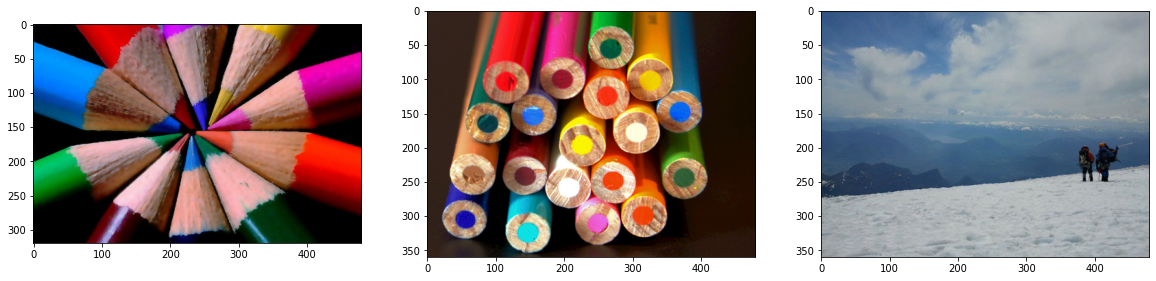

Image 1 size:  (320, 480, 3)
Image 2 size:  (360, 480, 3)
Image 3 size:  (360, 480, 3)


In [2]:
img1 = imageio.imread("images/pencil_RGB.png")
img2 = imageio.imread("images/pencil2_RGB.png")
img3 = imageio.imread("images/mountain.jpg")
plt.figure(figsize=(20,10))
plt.subplot(131); plt.imshow(img1)
plt.subplot(132); plt.imshow(img2)
plt.subplot(133); plt.imshow(img3)
plt.show()

print("Image 1 size: ", str(img1.shape))
print("Image 2 size: ", str(img2.shape))
print("Image 3 size: ", str(img3.shape))

We want to define a method that gets any colour image as input and outputs a vector $\in R^m$ so that we are able to write distance functions between images in this space of colour attributes (often called features space) with $m$ dimensions.

A simple way to do it would be to use the histograms of all RGB channels

In [3]:
def global_histogram(img, bins, norm='sum', factor=512):

    # single color channel
    if (len(img.shape) == 2):
        hist,_ = np.histogram(img, bins=bins)
    # RGB
    if (len(img.shape) == 3):
        hist_R,_ = np.histogram(img[:,:,0], bins=bins)
        hist_G,_ = np.histogram(img[:,:,1], bins=bins)
        hist_B,_ = np.histogram(img[:,:,2], bins=bins)
        hist = np.concatenate([hist_R, hist_G, hist_B])

    # normalizes resulting histogram
    hist = hist.astype(float)
    if (norm == 'sum'):
        hist /= (hist.sum() + 0.0001)        
    if (norm == 'value'):
        hist /= (hist.max() + 0.0001)        
        hist *= factor
        hist = hist.astype(int)
    
    return hist

In [6]:
rgbh_1 = global_histogram(img1, 256)
rgbh_2 = global_histogram(img2, 256)
rgbh_3 = global_histogram(img3, 256)

# printing the vector size
print(rgbh_1.shape)

(768,)


### Distance functions
In addition to defining a method for extracting a feature vector, it is important to define distance functions that operate on those vectors. Formally we want a function $d:R^m \rightarrow R^1$.

The Euclidean distance, or l-2 norm distance is the most widely used. Considering a pair of vectors $q$ and $p$ with $m$ dimensions each, it can be computed as

In [7]:
def Euclidean_distance(p, q):
    dist = np.sqrt(np.sum(np.square(p-q)))
    return dist

In [9]:
print("Distance 1-2 = %.4f" % (Euclidean_distance(rgbh_1, rgbh_2)))
print("Distance 1-3 = %.4f" % (Euclidean_distance(rgbh_1, rgbh_3)))
print("Distance 2-3 = %.4f" % (Euclidean_distance(rgbh_2, rgbh_3)))

Distance 1-2 = 0.1258
Distance 1-3 = 0.1388
Distance 2-3 = 0.1555


Comparing the distances we note that indeed the images 1 and 2 are closer when compared to the distances between 1 and 3 and 2 and 3.

However, one problem is the high dimensionality of the features space, with $m=768$. One way to reduce would be to quantise the histograms into less bins, e.g. 16 bins each.

In [11]:
rgbh_1 = global_histogram(img1, 16)
rgbh_2 = global_histogram(img2, 16)
rgbh_3 = global_histogram(img3, 16)

print("Feature vector size = %d " % (rgbh_1.shape[0]))
print("Distance 1-2 = %.3f" % (Euclidean_distance(rgbh_1, rgbh_2)))
print("Distance 1-3 = %.3f" % (Euclidean_distance(rgbh_1, rgbh_3)))
print("Distance 2-3 = %.3f" % (Euclidean_distance(rgbh_2, rgbh_3)))

Feature vector size = 48 
Distance 1-2 = 0.120
Distance 1-3 = 0.280
Distance 2-3 = 0.261


Another approach is to obtain a single channel from the RGB image, combining the colour channels using a RGB to grayscale conversion. There are many methods, such as Intensity, Luminance, Luma and other. Let us use the Luminance, which is a weighted averabe of the colour channels.

In [12]:
def normalize_minmax(f, factor):
    f_min = np.min(f)
    f_max = np.max(f)
    f = (f - f_min)/(f_max-f_min)
    return (f*factor)

def Luminance(img):
    img = np.array(img, copy=True).astype(float)
    # computing conversion
    new_img = np.zeros((img.shape[0], img.shape[1]))
    new_img = img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114
    new_img = normalize_minmax(new_img, 255)
    
    return new_img

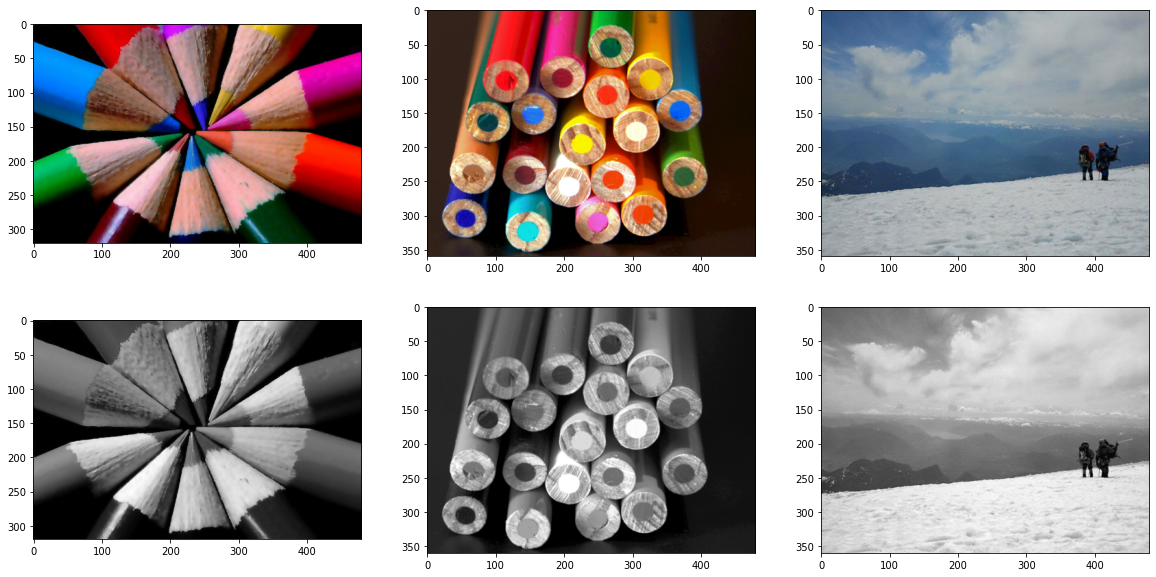

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(231); plt.imshow(img1)
plt.subplot(232); plt.imshow(img2)
plt.subplot(233); plt.imshow(img3)
plt.subplot(234); plt.imshow(Luminance(img1), cmap="gray")
plt.subplot(235); plt.imshow(Luminance(img2), cmap="gray")
plt.subplot(236); plt.imshow(Luminance(img3), cmap="gray")

plt.show()

In [15]:
gh_1 = global_histogram(Luminance(img1), 32)
gh_2 = global_histogram(Luminance(img2), 32)
gh_3 = global_histogram(Luminance(img3), 32)

print("Feature vector size = %d " % (gh_1.shape[0]))
print("Distance 1-2 = %.3f" % (Euclidean_distance(gh_1, gh_2)))
print("Distance 1-3 = %.3f" % (Euclidean_distance(gh_1, gh_3)))
print("Distance 2-3 = %.3f" % (Euclidean_distance(gh_2, gh_3)))

Feature vector size = 32 
Distance 1-2 = 0.199
Distance 1-3 = 0.285
Distance 2-3 = 0.282


Therefore, even after projecting the RGB colour space into a single-channel space, it is possible to obtain a fair comparison between the images. 

However, we used images that are easy to discriminate. More complex cases would require methods that are able to capture other attributes in terms of colour, such as considering the regions the colour appears: flat regions, texture regions, borders, and not only the frequency of colours as demonstrated.

Alternative distance functions are also important to consider. For colour features spaces, the logarithm function may be useful to decrease the influence of background colours in the sum, and output smaller numbers.



In [16]:
def Log_Euclidean_distance(p, q):
    pl = np.log2(p.astype(float)+1)
    ql = np.log2(q.astype(float)+1)
    
    dist = np.sqrt(np.sum(np.square(pl-ql)))
    return dist

In [17]:
gh_1 = global_histogram(Luminance(img1), 48, "value")
gh_2 = global_histogram(Luminance(img2), 48, "value")
gh_3 = global_histogram(Luminance(img3), 48, "value")

print("Log Euclidean distances")
print("Distance 1-2 = %.3f" % (Log_Euclidean_distance(gh_1, gh_2)))
print("Distance 1-3 = %.3f" % (Log_Euclidean_distance(gh_1, gh_3)))
print("Distance 2-3 = %.3f" % (Log_Euclidean_distance(gh_2, gh_3)))

Log Euclidean distances
Distance 1-2 = 8.169
Distance 1-3 = 18.299
Distance 2-3 = 20.599
